# Neural network development for turbulence modeling in URANS simulations of non-Newtonian media slope flows

URANS mathematical model:
\begin{equation}
	\label{vof}
	\left\{
		\begin{aligned}
			&\boldsymbol{\nabla} \cdot \bar{\boldsymbol{u}} = 0,\\
			&\frac{\partial \bar{\alpha}}{\partial t} + \boldsymbol{\nabla} \cdot (\bar{\boldsymbol{u}} \bar{\alpha}) = 0,\\
			&\frac{\partial (\rho \bar{\boldsymbol{u}})}{\partial t} + \boldsymbol{\nabla} \cdot (\rho \bar{\boldsymbol{u}} \bar{\boldsymbol{u}}) = -\boldsymbol{\nabla} \bar{p} + \boldsymbol{\nabla} \cdot \bar{\boldsymbol{\tau}} + \rho \bar{\boldsymbol{f}}.
		\end{aligned}
	\right.
\end{equation}
Here $\bar{\boldsymbol{u}}$ is the speed of the mixture, horizontal bar means Reynolds averaging, $\bar{\alpha}$ is the volume fraction of the selected phase, $\bar{\boldsymbol{\tau}} = \bar{\boldsymbol{\tau}}_{Re} + \bar{\boldsymbol{\tau}}_m$ is the stress tensor calculated as sum of Reynolds stress tensor and viscous stress tensor, $\bar{\boldsymbol{\tau}}_m = 2 \mu \bar{\boldsymbol{s}}$ is the viscous stress tensor, which is a function of the strain rate tensor $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$, $\mu = \nu \rho$ is dynamic viscosityof a mixture which is calculated as a product of density and kinematic viscosity of mixture, $\nu = \nu_1 \bar{\alpha} + \nu_0 (1 -\bar{\alpha})$ is the kinemsatic viscosity of mixture calculated according to the principle of the weighted average, $\nu_0$ is a constant, $\nu_1 = min (\nu_*, (\tau_* + K \dot{\gamma}^n) / \dot{\gamma})$ is Herschel-Bulkley reology ratio, $\rho = \rho_1 \bar{\alpha} + \rho_0 (1 - \bar{\alpha})$ is the mixture density, $\rho_0$ and $\rho_1$ are constants, $\bar{p}$ is the pressure, $\bar{\boldsymbol{f}}$ is the density of the body forces.

The $\bar{\boldsymbol{\tau}}_{Re}$ Reynolds stress tensor is calculetaed using Tensor Basis Neural Network (TBNN) according to the principle presented in the work of Pope [1]. It is presented as function of strain rate $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ and rotation rate $\bar{\boldsymbol{r}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} - (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ tensors, and 10 their isotropic combinations $T^i$ and 5 invariants $\lambda_i$. Calculations performed for normalized tensors $\bar{\tau}_{Re}'$, $\bar{\boldsymbol{s}}'$, $\bar{\boldsymbol{r}}'$. The scaling parameters $U_0$, $h_0$, $\rho$ used for normalization:

\begin{equation}
	\label{norm}
	\left\{
		\begin{aligned}
			&\bar{\boldsymbol{\tau}}_{Re} = \bar{\boldsymbol{\tau}}_{Re}' \rho U_0 h_0,\\
			&\bar{\boldsymbol{s}} = \bar{\boldsymbol{s}}' U_0^2 / h_0,\\
			&\bar{\boldsymbol{r}} = \bar{\boldsymbol{r}}' U_0^2 / h_0.
		\end{aligned}
	\right.
\end{equation}

In what follows, we omit the apostrophe symbol and keep in mind that we are considering normalized tensors.

Normalized Reynolds stress tensor is

\begin{equation}
	\label{MLReynolds}
	\bar{\boldsymbol{\tau}}_{Re} = \sum\limits_{n=1}^{10} g^{(n)} (\lambda_1, ... , \lambda_5) \boldsymbol{T}^{(n)}.
\end{equation}

\begin{equation}
	\begin{aligned}
		&\boldsymbol{T}^{(1)} = \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(6)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} + \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \frac{2}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(2)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} - \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(7)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} \bar{\boldsymbol{r}},\\
		&\boldsymbol{T}^{(3)} = \bar{\boldsymbol{s}}^2 - \frac{1}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2),
		&&\boldsymbol{T}^{(8)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},\\
		&\boldsymbol{T}^{(4)} = \bar{\boldsymbol{r}}^2 - \frac{1}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{r}}^2),
		&&\boldsymbol{T}^{(9)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 + \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \frac{2}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(5)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
		&&\boldsymbol{T}^{(10)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
	\end{aligned}
\end{equation}
\begin{equation}
	\lambda_1 = Tr(\bar{\boldsymbol{s}}^2),\ \ \ \ \lambda_2 = Tr(\bar{\boldsymbol{r}}^2),\ \ \ \ \lambda_3 = Tr(\bar{\boldsymbol{s}}^3),\ \ \ \ \lambda_4 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}),\ \ \ \ \lambda_5 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2).
\end{equation}

Calculations performed for turbulent flow in inclined chute with the rectangular cross-section. Scheme of flow is shown in figure below.

<div>
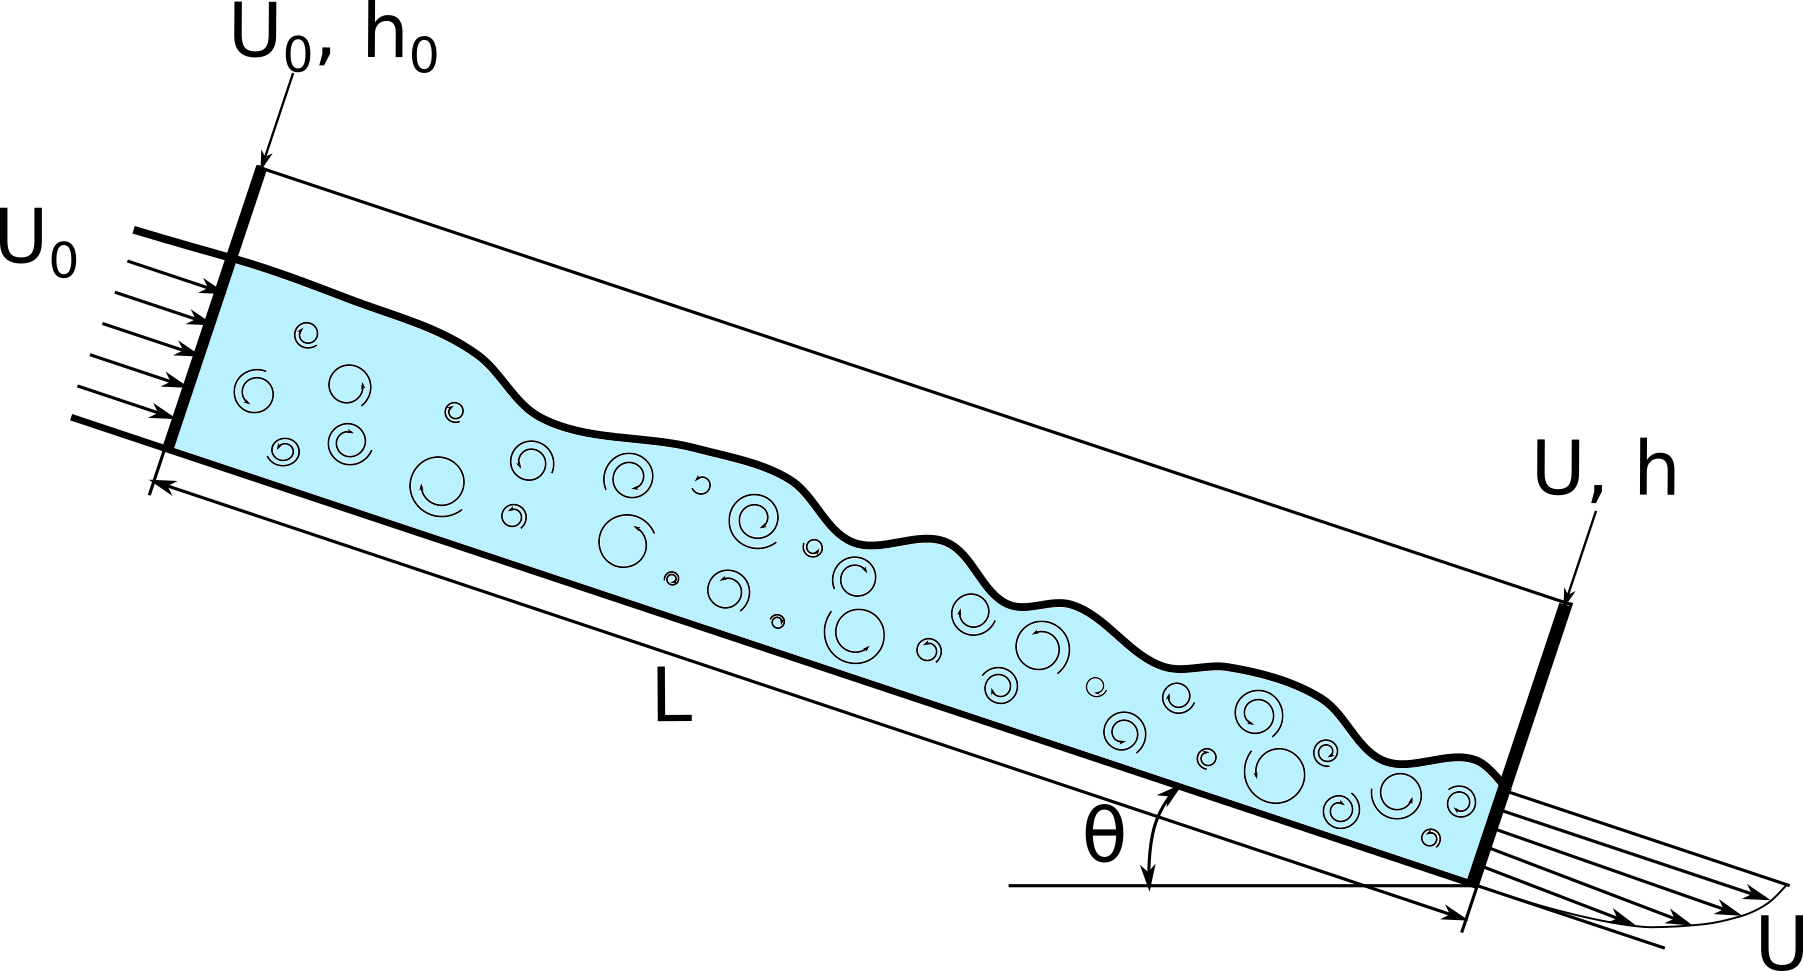
</div>

In the considered flow
\begin{equation}
    U_0 = 0.4\ \text{m}/\text{s},\ \ \ h_0 = 0.01\ \text{m},\ \ \ \theta = 25^\circ,\ \ \ L = 0.1\ \text{m}.
\end{equation}

Reynolds number of flow is 
\begin{equation}
    \text{Re} = U_0 h_0 / \nu_{eff},
\end{equation}

\begin{equation}
    \nu_{eff} = \frac{\tau_* + K (U_0/h_0)^n}{\rho (U_0 / h_0)}.
\end{equation}

Constants in calculation are set as follows:

\begin{equation}
    \nu_* = 10^7\ \text{m}^2/\text{s},\ \ \ \tau_* = 2 \cdot 10^{-3}\ \text{m}^2/\text{s}^2,\ \ \ K = 10^{-4}\ \text{m}^2/\text{s},\ \ \ n = 0.8,\ \ \ \rho = 100\ \text{kg}/\text{m}^3.
\end{equation}

So effective viscosity and Reynolds number are:

\begin{equation}
    \nu_{eff} = 10^{-6}\ \text{m}^2/\text{s},\ \ \ \text{Re} = 4000.
\end{equation}

The mesh cell linear size must be $dx = \frac{h_0}{\text{Re}^{3/4}} = 2 \cdot 10^{-5}$. Time step $dt = 5 \cdot 10^{-5}$.

Mesh size for computational domain size of 0.1x0.011x0.002 m$^3$ is $27.5 \cdot 10^7$.

[1] S. B. Pope. A more general effective-viscosity hypothesis.Journal of Fluid Mechanics,72(2):331–340, 1975.

## Current research

Above was global formulation for TBNN (Tensor Based Neural Network) with implemengtation into mathematical model. Now let's try to realize ML-turbulence model as a correction step for variables $\bar{\boldsymbol{u}}$, $\bar{\alpha}$, $\bar{p}$.

Will use tensors $\boldsymbol{T}^{(i)}$, invariants $\lambda_i$ and variables $\bar{\boldsymbol{u}}$, $\bar{p}$, $\bar{\alpha}$ as a features of NN (Neural Network). As a targets will be the differenses between DNS and RANS values for $\boldsymbol{u}$, $\alpha$ and $p$.

Let's start with importing libraries.

In [1]:
!pip install git+https://github.com/tensorflow/docs
!pip install -q -U keras-tuner

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7x2ltv99
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-7x2ltv99
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=151722 sha256=e33402e270464df49247a55fb6243020272dfa7b1e969f7a8dc4be93fafba913
  Stored in directory: /tmp/pip-ephem-wheel-cache-eqp0pp9h/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner as kt
import subprocess as sp
import fileinput as fi

print(tf.__version__)

2.7.0


In [46]:
def timeStepsList():
    timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
    index = np.argsort(timeStepsList.astype(np.float))
    timeStepsList = timeStepsList[index]
    #return np.asarray(timeStepsList[1:-2], dtype=str)
    return timeStepsList[1:-2]

In [66]:
def readTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr

In [32]:
def readSymmTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr[[fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'8']]

In [33]:
def readVector(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr

In [34]:
def readScalar(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.columns = [fileName[0]]
    arr.loc[:] = arr.loc[:].astype(float)
    return arr

In [35]:
def prepareLabels(data):
    data['dU0'] = (data['res/Uref0'] - data['res/U0']) / data['res/Uref0']
    data['dU1'] = (data['res/Uref1'] - data['res/U1']) / data['res/Uref1']
    data['dU2'] = (data['res/Uref2'] - data['res/U2']) / data['res/Uref2']
    data['dAW'] = (data['res/AWref'] - data['res/alpha.water']) / data['res/AWref']
    data['dp'] = (data['res/p_rghref'] - data['res/p_rgh']) / data['res/p_rghref']

In [81]:
def formDataset(TSL, TSLlen, folder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size):
    data = pd.DataFrame()
    for time in TSL:
        if TSLlen == 1:
            time = TSL
        kwargs = {'folder':folder, 'time':time, 'sz':size}
        scalars = FsScalars.apply(readScalar, axis=1, **kwargs)
        vectors = FsVectors.apply(readVector, axis=1, **kwargs)
        tensors = FsTensors.apply(readTensor, axis=1, **kwargs)
        symmTensors = FsSymmTensors.apply(readSymmTensor, axis=1, **kwargs)
        tmp = pd.concat(list(scalars[:])+list(vectors[:])+list(tensors[:])+list(symmTensors[:]), axis=1)
        data = data.append(tmp, ignore_index=True)
        prepareLabels(data)
        if TSLlen == 1:
            break
    return data

In [128]:
def writePrediction(arr, arrType, time, folder, fileName):
    sp.run('cp '+folder+time+'/patterns/'+fileName+'PatternBeginning '+folder+time+'/'+ time+'/'+fileName, shell=True, check=True)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as f:
        f.write(str(len(arr))+'\n(\n')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('folderName', '"'+time+'"'), end='')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('fieldName', fileName), end='')
    if arrType == 'vector':
        arr = arr.astype(str)
        arr = '( '+arr.iloc[:,0]+' '+arr.iloc[:,1]+' '+arr.iloc[:,2]+' )'
    elif arrType == 'scalar':
        arr = arr.astype(str)
    arr.to_csv(folder+time+'/'+time+'/'+fileName, mode='a', index=False, header=False)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as\
        fout, fi.input(folder+time+'/'+'patterns/'+fileName+'PatternEnding') as fin:
            for line in fin:
                fout.write(line)

In [127]:
#writePrediction(testLastData[['dU0', 'dU1', 'dU2']], 'vector', testLastTSL, MLturbRANSfolder ,'dU')
writePrediction(testLastData[['dp']], 'scalar', testLastTSL, MLturbRANSfolder ,'dp')

Below all fiatures listed. alpha.water is $\bar{\alpha}$, 'alpha.water', 'U' and 'p_rgh' are initial values. Parameters from res/ folder are calculated without turbulence model using base interFoam solver. 'Uref', 'AWref' and 'p_rghref' are reference values calculated using DNS data.

In [69]:
TSL = timeStepsList()
testTSL = TSL[[int(len(TSL)/2), -1]]
testCenterTSL = TSL[int(len(TSL)/2)]
testLastTSL = TSL[-1]
TSL = np.delete(TSL, [int(len(TSL)/2), -1])
TSL = TSL[:3]
lenTSL = len(TSL)
MLturbRANSfolder = 'TIF'
KEturbRANSfolder = 'KEIF'
KWturbRANSfolder = 'KWIF'
deltaT = 1e-06
size = 300000
FsScalars = pd.DataFrame([['alpha.water'], ['res/alpha.water'], ['res/AWref'], ['p_rgh'], ['res/p_rgh'],\
                          ['res/p_rghref']])#, ['res/I0'], ['res/I1'], ['res/I2'], ['res/I3'], ['res/I4']])
FsVectors = pd.DataFrame([['U'], ['res/U'], ['res/Uref'], ['res/gradP'], ['res/gradAW']])
FsTensors = pd.DataFrame([['res/rotationRateTensor']])
FsSymmTensors = pd.DataFrame([['res/T0']])#, ['res/T1'], ['res/T2'], ['res/T3'], ['res/T4'], ['res/T5'], \
                          #['res/T6'], ['res/T7'], ['res/T8'], ['res/T9']])

In [59]:
print(TSL)
print(testTSL)
print(testCenterTSL)
print(len(testCenterTSL))
print(testLastTSL)

['1e-06' '2e-06' '3e-06']
['1e-05' '1.8e-05']
1e-05
5
1.8e-05


In [84]:
len(testLastData)

300000

In [82]:
#trainData = formDataset(TSL, len(TSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
#testData = formDataset(testTSL, len(testTSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
#testCenterData = formDataset(testCenterTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
testLastData = formDataset(testLastTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)

#testKEData = formDataset(testTSL, KEturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
#testKECenterData = formDataset(testCenterTSL, KEturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
#testKELastData = formDataset(testLastTSL, KEturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)

#testKWData = formDataset(testTSL, KWturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
#testKWCenterData = formDataset(testCenterTSL, KWturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)
#testKWLastData = formDataset(testLastTSL, KWturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors, size)

trainData.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
alpha.water,900000.0,6.666667e-06,1.762547e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.001879e-03
res/alpha.water,900000.0,9.966496e-06,2.528643e-04,-1.910308e-18,0.000000e+00,0.000000e+00,0.000000e+00,7.997409e-03
res/AWref,900000.0,1.000000e-05,2.536566e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.002582e-03
p_rgh,900000.0,-7.164958e-01,2.546062e+00,-8.702251e+01,-2.086210e-01,-7.835997e-03,-3.599748e-04,-1.878501e-06
res/p_rgh,900000.0,-5.098305e+01,6.200734e+00,-1.185622e+02,-5.098779e+01,-4.893160e+01,-4.879625e+01,-7.370670e+00
res/p_rghref,900000.0,-3.629563e-01,1.167881e+00,-3.547066e+01,-1.185950e-01,-4.554788e-03,-2.321551e-04,-1.631294e-06
U0,900000.0,2.438208e-02,6.518951e-02,-5.175734e-01,1.319692e-05,3.492725e-04,9.295609e-03,4.334699e-01
U1,900000.0,6.083705e-08,1.747383e-05,-1.228032e-03,-1.061186e-10,7.955732e-13,1.069103e-10,1.231047e-03
U2,900000.0,2.302422e-02,6.299398e-02,-7.070315e-03,1.353246e-05,3.578612e-04,9.397556e-03,8.102427e-01
res/U0,900000.0,2.435141e-02,6.585592e-02,-5.210327e-01,1.079673e-05,3.107216e-04,8.819893e-03,4.445710e-01


In [ ]:
train_features = trainData.copy()
train_labels = train_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
train_features = train_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp'], axis=1)

#test_features = testData.copy()
#test_labels = test_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
#test_features = test_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp'], axis=1)

#test_center_features = testCenterData.copy()
#test_center_labels = test_center_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
#test_center_features = test_center_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp'], axis=1)

#test_last_features = testLastData.copy()
#test_last_labels = test_last_features[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
#test_last_features = test_last_features.drop(['dU0', 'dU1', 'dU2', 'dAW', 'dp'], axis=1)

In [ ]:
sns.pairplot(trainData[['res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4']], diag_kind='kde')

In [ ]:
sns.pairplot(trainData[['dU0', 'dU1', 'dU2', 'dAW', 'dp',\
                   'res/U0', 'res/U1', 'res/U2', 'res/alpha.water', 'res/p_rgh']], diag_kind='kde')

In [ ]:
dU0TargetCorr = trainData.corr()['dU0']
print(dU0TargetCorr.abs().sort_values()[:10])
print(dU0TargetCorr.abs().sort_values()[-10:])

In [ ]:
dU1TargetCorr = trainData.corr()['dU1']
print(dU1TargetCorr.abs().sort_values()[:10])
print(dU1TargetCorr.abs().sort_values()[-10:])

In [ ]:
dU2TargetCorr = trainData.corr()['dU2']
print(dU2TargetCorr.abs().sort_values()[:10])
print(dU2TargetCorr.abs().sort_values()[-10:])

In [ ]:
dAWTargetCorr = trainData.corr()['dAW']
print(dAWTargetCorr.abs().sort_values()[:10])
print(dAWTargetCorr.abs().sort_values()[-10:])

In [ ]:
dpTargetCorr = trainData.corr()['dp']
print(dpTargetCorr.abs().sort_values()[:10])
print(dpTargetCorr.abs().sort_values()[-10:])

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

I0 correlates good with dU0

In [19]:
I0 = np.array(train_features['res/I0'])
I0_normalizer = layers.Normalization(input_shape=[1,], axis=None)
I0_normalizer.adapt(I0)

In [20]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [21]:
dnn_I0_model = build_and_compile_model(I0_normalizer)

In [22]:
dnn_I0_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [23]:
%%time
history_dnn_I0 = dnn_I0_model.fit(
    train_features['res/I0'],
    train_labels['dU0'],
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 15min 51s, sys: 2min 20s, total: 18min 12s
Wall time: 7min 48s


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

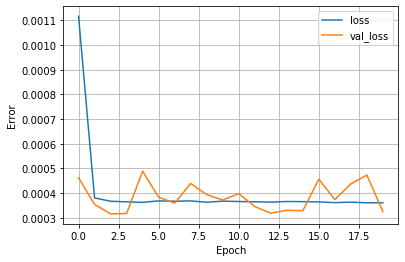

In [25]:
plot_loss(history_dnn_I0)

In [26]:
data['res/I0'].describe()

count    4.950000e+05
mean     3.786017e+04
std      2.247555e+05
min      2.919963e-08
25%      1.670147e-04
50%      1.257109e-01
75%      9.253296e+01
max      4.752991e+06
Name: res/I0, dtype: float64

In [27]:
x = tf.linspace(0., 6000000., 101)
y = dnn_I0_model.predict(x)

In [28]:
def plot_I0(x, y):
  plt.scatter(train_features['res/I0'], train_labels['dU0'], label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('I0')
  plt.ylabel('dU0')
  #plt.ylim([-0.007, 0.04])
  plt.legend()

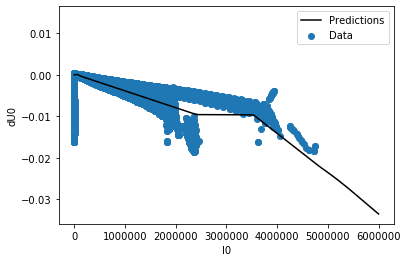

In [29]:
plot_I0(x, y)

In [30]:
test_results = {}

In [31]:
test_results['dnn_I0_model'] = dnn_I0_model.evaluate(
    test_features['res/I0'], test_labels['dU0'],
    verbose=0)

U1 has bad correlation with dU0

In [32]:
U1 = np.array(train_features['res/U1'])
U1_normalizer = layers.Normalization(input_shape=[1,], axis=None)
U1_normalizer.adapt(U1)

In [33]:
dnn_U1_model = build_and_compile_model(U1_normalizer)

In [34]:
%%time
history_dnn_U1 = dnn_U1_model.fit(
    train_features['res/U1'],
    train_labels['dU0'],
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 15min 53s, sys: 2min 21s, total: 18min 15s
Wall time: 7min 50s


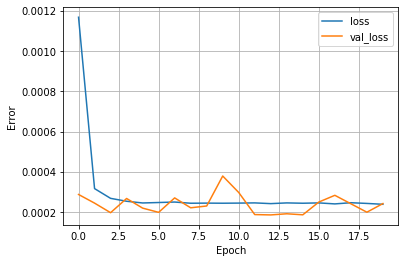

In [35]:
plot_loss(history_dnn_U1)

In [36]:
data['res/U1'].describe()

count    4.950000e+05
mean     3.586589e-09
std      3.827058e-06
min     -3.848347e-04
25%     -6.089229e-10
50%      1.013892e-10
75%      1.024275e-09
max      3.848721e-04
Name: res/U1, dtype: float64

In [37]:
x = tf.linspace(-0.084, 0.084, 101)
y = dnn_U1_model.predict(x)

In [38]:
def plot_U1(x, y):
  plt.scatter(train_features['res/U1'], train_labels['dU0'], label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('U1')
  plt.ylabel('dU0')
  #plt.ylim([-0.007, 0.04])
  plt.legend()

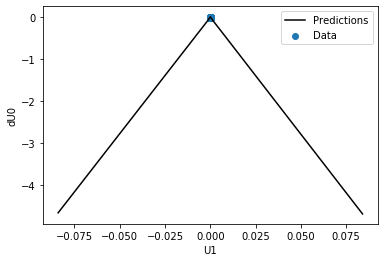

In [39]:
plot_U1(x,y)

In [40]:
test_results['dnn_U1_model'] = dnn_U1_model.evaluate(
    test_features['res/U1'], test_labels['dU0'],
    verbose=0)

In [41]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 86)               173       
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                5568      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,966
Trainable params: 9,793
Non-trainable params: 173
_________________________________________________________________


In [42]:
%%time
history_dnn = dnn_model.fit(
    train_features,
    train_labels['dU0'],
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 17min 31s, sys: 2min 44s, total: 20min 15s
Wall time: 8min 30s


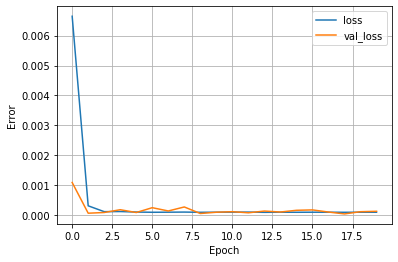

In [43]:
plot_loss(history_dnn)

In [44]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels['dU0'], verbose=0)

In [45]:
pd.DataFrame(test_results, index=['Mean absolute error [dU0]']).T

,Mean absolute error [dU0]
dnn_I0_model,0.000327
dnn_U1_model,0.000245
dnn_model,0.000133


In [46]:
test_predictions = dnn_model.predict(test_features).flatten()

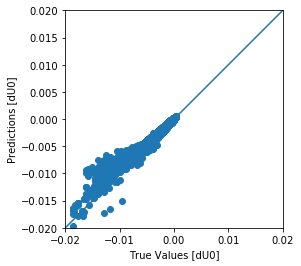

In [47]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels['dU0'], test_predictions)
plt.xlabel('True Values [dU0]')
plt.ylabel('Predictions [dU0]')
lims = [-0.02, 0.02]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

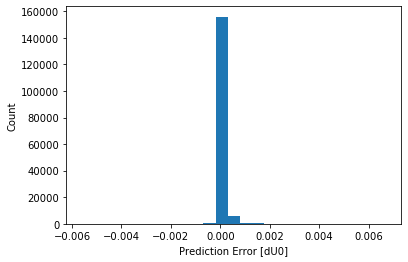

In [48]:
error = test_predictions - test_labels['dU0']
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [dU0]')
_ = plt.ylabel('Count')

In [49]:
AE_model = keras.Sequential([
    normalizer,
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])
AE_model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

In [50]:
%%time
history_AE = AE_model.fit(
    train_features,
    train_labels['dU0'],
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 14min 29s, sys: 2min 18s, total: 16min 47s
Wall time: 7min 37s


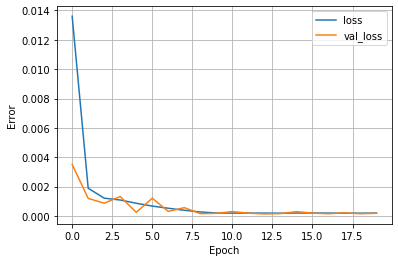

In [51]:
plot_loss(history_AE)

In [52]:
test_results['AE_model'] = AE_model.evaluate(test_features, test_labels['dU0'], verbose=0)

In [53]:
pd.DataFrame(test_results, index=['Mean absolute error [dU0]']).T

,Mean absolute error [dU0]
dnn_I0_model,0.000327
dnn_U1_model,0.000245
dnn_model,0.000133
AE_model,0.000189


In [54]:
N_VALIDATION = len(test_features)
print(N_VALIDATION)
N_TRAIN = len(train_features)
print(N_TRAIN)
BUFFER_SIZE = N_TRAIN
print(BUFFER_SIZE)
BATCH_SIZE = 5000
print(BATCH_SIZE)
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
print(STEPS_PER_EPOCH)
N_LABELS = len(labels.columns)
print(N_LABELS)

163350
331650
331650
5000
66
5


In [55]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*10,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [56]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=[tf.keras.metrics.MeanAbsoluteError(
                      name='mean_absolute_error')])
                  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  #metrics=[
                  #    tf.keras.losses.BinaryCrossentropy(
                  #        from_logits=True, name='binary_crossentropy'),
                  #    'accuracy'])

    model.summary()

    history = model.fit(
        train_features,
        train_labels,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=0.2,
        verbose=0)
    return history

In [57]:
full_dnn_model_1 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [58]:
full_architecture_histories = {}

In [59]:
%%time
full_architecture_histories['full_dnn_model_1'] = compile_and_fit(
    full_dnn_model_1,
    'full_dnn_model_1',
    max_epochs=500)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 86)               173       
 n)                                                              
                                                                 
 dense_11 (Dense)            (None, 64)                5568      
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                                                 
Total params: 6,066
Trainable params: 5,893
Non-trainable params: 173
_________________________________________________________________
CPU times: user 1h 29min 54s, sys: 8min 11s, total: 1h 38min 5s
Wall time: 46min 50s


In [60]:
full_dnn_model_2 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [61]:
%%time
full_architecture_histories['full_dnn_model_2'] = compile_and_fit(
    full_dnn_model_2,
    'full_dnn_model_2',
    max_epochs=500)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 86)               173       
 n)                                                              
                                                                 
 dense_13 (Dense)            (None, 64)                5568      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 5)                 325       
                                                                 
Total params: 10,226
Trainable params: 10,053
Non-trainable params: 173
_________________________________________________________________
CPU times: user 1h 32min 31s, sys: 7min 14s, total: 1h 39min 45s
Wall time: 41min 6s


In [62]:
full_dnn_model_3 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [63]:
%%time
full_architecture_histories['full_dnn_model_3'] = compile_and_fit(
    full_dnn_model_3,
    'full_dnn_model_3',
    max_epochs=500)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 86)               173       
 n)                                                              
                                                                 
 dense_16 (Dense)            (None, 64)                5568      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 14,386
Trainable params: 14,213
Non-trainable params: 173
________________________________________________

In [64]:
full_dnn_model_4 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [65]:
%%time
full_architecture_histories['full_dnn_model_4'] = compile_and_fit(
    full_dnn_model_4,
    'full_dnn_model_4',
    max_epochs=500)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 86)               173       
 n)                                                              
                                                                 
 dense_20 (Dense)            (None, 64)                5568      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 5)                 325       
                                                      

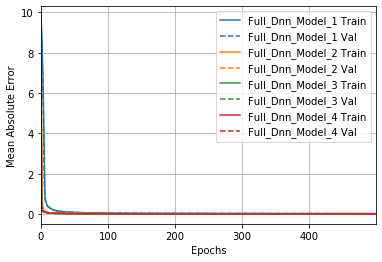

In [66]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(full_architecture_histories)
#plt.ylim([0., 0.05])

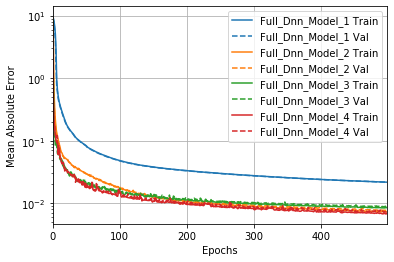

In [67]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(full_architecture_histories)
plt.yscale('log')

(0.0, 0.05)

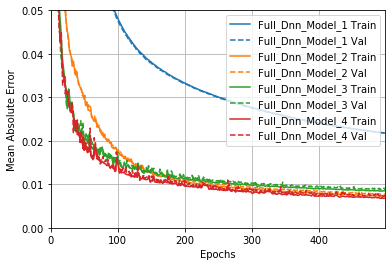

In [68]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(full_architecture_histories)
plt.ylim([0., 0.05])

In [129]:
full_dnn_models = {}
full_dnn_models['full_dnn_model_1'] = full_dnn_model_1.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['full_dnn_model_2'] = full_dnn_model_2.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['full_dnn_model_3'] = full_dnn_model_3.evaluate(
    test_features,
    test_labels,
    verbose=0)
full_dnn_models['full_dnn_model_4'] = full_dnn_model_4.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [130]:
pd.DataFrame(full_dnn_models).T

,0,1
full_dnn_model_1,0.022114,0.022114
full_dnn_model_2,0.007618,0.007618
full_dnn_model_3,0.008678,0.008678
full_dnn_model_4,0.007310,0.007310
full_dnn_model_1_do,0.266288,0.266288
full_dnn_model_2_do,0.395311,0.395311
full_dnn_model_3_do,0.340926,0.340926
full_dnn_model_4_do,0.389947,0.389947
full_dnn_model_1_l1,0.189572,0.031607
full_dnn_model_2_l1,0.263559,0.017377


In [131]:
def model_builder_full_dnn_3_units_lr(hp):
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model = keras.Sequential([
        normalizer,
        layers.Dense(units=hp_units1, activation='relu'),
        layers.Dense(units=hp_units2, activation='relu'),
        layers.Dense(units=hp_units3, activation='relu'),
        layers.Dense(N_LABELS)
    ])
    model.compile(#optimizer=get_optimizer(),
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_absolute_error',
                  metrics=[tf.keras.metrics.MeanAbsoluteError(
                      name='mean_absolute_error')])
    return model

In [132]:
tuner = kt.Hyperband(model_builder_full_dnn_3_units_lr,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3)#,
                     #directory='my_dir',
                     #project_name='hp_tuning_HB')

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [133]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [134]:
%%time
tuner.search(
    train_features,
    train_labels,
    epochs=100,
    validation_split=0.2,
    callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit
CPU times: user 3.73 ms, sys: 0 ns, total: 3.73 ms
Wall time: 2.66 ms


In [135]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, the optimal number of units in the second densely-connected
layer is {best_hps.get('units2')}, the optimal number of units in the third densely-connected
layer is {best_hps.get('units3')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96, the optimal number of units in the second densely-connected
layer is 128, the optimal number of units in the third densely-connected
layer is 160, the optimal learning rate for the optimizer
is 0.0001.



In [136]:
full_dnn_3_units_lr = tuner.hypermodel.build(best_hps)
history_full_dnn_3_units_lr = full_dnn_3_units_lr.fit(
    train_features,
    train_labels,
    epochs=300,
    validation_split=0.2)

Epoch 1/300
8292/8292 [==============================] - 49s 6ms/step - loss: 0.5413 - mean_absolute_error: 0.5413 - val_loss: 0.0517 - val_mean_absolute_error: 0.0517
Epoch 2/300
8292/8292 [==============================] - 47s 6ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0272 - val_mean_absolute_error: 0.0272
Epoch 3/300
8292/8292 [==============================] - 49s 6ms/step - loss: 0.0275 - mean_absolute_error: 0.0275 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 4/300
8292/8292 [==============================] - 50s 6ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 5/300
8292/8292 [==============================] - 55s 7ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 6/300
8292/8292 [==============================] - 58s 7ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0250 - val_mean_absolute_error:

8292/8292 [==============================] - 41s 5ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 50/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 51/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 52/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 53/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 54/300
8292/8292 [==============================] - 45s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107

8292/8292 [==============================] - 42s 5ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0138 - val_mean_absolute_error: 0.0138
Epoch 98/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157
Epoch 99/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 100/300
8292/8292 [==============================] - 40s 5ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0132 - val_mean_absolute_error: 0.0132
Epoch 101/300
8292/8292 [==============================] - 40s 5ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 102/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0102 - val_mean_absolute_error: 0.0

8292/8292 [==============================] - 40s 5ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 146/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 147/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 148/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0105 - mean_absolute_error: 0.0105 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 149/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 150/300
8292/8292 [==============================] - 46s 6ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0145 - val_mean_absolute_error: 0

8292/8292 [==============================] - 41s 5ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0108 - val_mean_absolute_error: 0.0108
Epoch 194/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 195/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064
Epoch 196/300
8292/8292 [==============================] - 40s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 197/300
8292/8292 [==============================] - 42s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 198/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0087 - val_mean_absolute_error: 0

8292/8292 [==============================] - 40s 5ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 242/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 243/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 244/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 245/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 246/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0073 - val_mean_absolute_error: 0

8292/8292 [==============================] - 41s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 290/300
8292/8292 [==============================] - 42s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 291/300
8292/8292 [==============================] - 42s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0130 - val_mean_absolute_error: 0.0130
Epoch 292/300
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 293/300
8292/8292 [==============================] - 42s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0050 - val_mean_absolute_error: 0.0050
Epoch 294/300
8292/8292 [==============================] - 42s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0055 - val_mean_absolute_error: 0

NameError: name 'val_acc_per_epoch' is not defined

In [137]:
val_loss_per_epoch = history_full_dnn_3_units_lr.history['val_loss']
best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [138]:
full_dnn_models['full_dnn_3_units_lr'] = full_dnn_3_units_lr.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [139]:
pd.DataFrame(full_dnn_models).T

,0,1
full_dnn_model_1,0.022114,0.022114
full_dnn_model_2,0.007618,0.007618
full_dnn_model_3,0.008678,0.008678
full_dnn_model_4,0.007310,0.007310
full_dnn_model_1_do,0.266288,0.266288
full_dnn_model_2_do,0.395311,0.395311
full_dnn_model_3_do,0.340926,0.340926
full_dnn_model_4_do,0.389947,0.389947
full_dnn_model_1_l1,0.189572,0.031607
full_dnn_model_2_l1,0.263559,0.017377


In [140]:
test_center_features_prediction = full_dnn_3_units_lr_best.predict(test_center_features)
test_last_features_prediction = full_dnn_3_units_lr_best.predict(test_last_features)

NameError: name 'full_dnn_3_units_lr_best' is not defined

In [ ]:
class lnPusDense(Layer):

  def __init__(self, units=32):
      super(SimpleDense, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(max(inputs, ), self.w) + self.b

In [ ]:
inputs = keras.Input(shape=(784,))
full_dnn_model_1 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])